In this notebook I will try to load the Data on stability scores and understand how to use it.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from encoded_protein_dataset import EncodedProteinDataset, collate_fn, get_embedding
from encoded_protein_dataset_new import get_embedding, EncodedProteinDataset_new, collate_fn_new
from pseudolikelihood import get_npll_new
import torch
from potts_decoder import PottsDecoder
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
import scipy

import os
sys.path.insert(1, "C:/Users/Luca/OneDrive/Phd/Second_year/research/Feinauer/esm")
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained
from ioutils import read_fasta, read_encodings
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict


In [8]:
def load_structure(fpath, chain=None):
    """
    Args:
        fpath: filepath to either pdb or cif file
        chain: the chain id or list of chain ids to load
    Returns:
        biotite.structure.AtomArray
    """
    with open(fpath) as fin:
        pdbf = pdb.PDBFile.read(fin)
    structure = pdb.get_structure(pdbf, model=1)
    bbmask = filter_backbone(structure)
    structure = structure[bbmask]
    all_chains = get_chains(structure)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain is None:
        chain_ids = all_chains
    elif isinstance(chain, list):
        chain_ids = chain
    else:
        chain_ids = [chain] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in structure]
    structure = structure[chain_filter]
    return structure

def extract_coords_from_structure(structure: biotite.structure.AtomArray):
    """
    Args:
        structure: An instance of biotite AtomArray
    Returns:
        Tuple (coords, seq)
            - coords is an L x 3 x 3 array for N, CA, C coordinates
            - seq is the extracted sequence
    """
    coords = get_atom_coords_residuewise(["N", "CA", "C"], structure)
    residue_identities = get_residues(structure)[1]
    seq = ''.join([ProteinSequence.convert_letter_3to1(r) for r in residue_identities])
    return coords, seq

def get_atom_coords_residuewise(atoms: List[str], struct: biotite.structure.AtomArray):
    """
    Example for atoms argument: ["N", "CA", "C"]
    """
    def filterfn(s, axis=None):
        filters = np.stack([s.atom_name == name for name in atoms], axis=1)
        sum = filters.sum(0)
        if not np.all(sum <= np.ones(filters.shape[1])):
            raise RuntimeError("structure has multiple atoms with same name")
        index = filters.argmax(0)
        coords = s[index].coord
        coords[sum == 0] = float("nan")
        return coords

    return biotite.structure.apply_residue_wise(struct, struct, filterfn)

In [9]:
dir="D:/Data/InverseFolding/rocklin"
data1 = pd.read_csv(os.path.join(dir, "rd1_stability_scores"), sep="\t")
data2 = pd.read_csv(os.path.join(dir, "rd2_stability_scores"), sep="\t")
data3 = pd.read_csv(os.path.join(dir, "rd3_stability_scores"), sep="\t")
data4 = pd.read_csv(os.path.join(dir, "rd4_stability_scores"), sep="\t")
data_ss = pd.read_csv(os.path.join(dir, "ssm2_stability_scores"), sep="\t")

In [10]:
data4[1000:2000]

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore
1000,BBL_H142W+T152A,QNNDALSPAIRRLLAEWNLDASAIKGAGVGGRLTREDVEKHLAKAG...,4.0,2.25,2.2,2.3,0.1,0.89,1.37,0.65,3.00,3.0,3.0,0.0,1.17,1.82,0.87,0.65
1001,BBL_H142W+T152S,QNNDALSPAIRRLLAEWNLDASAIKGSGVGGRLTREDVEKHLAKAG...,4.0,3.99,4.0,4.0,0.0,0.91,3.08,1.47,3.32,3.3,3.4,0.1,1.18,2.14,1.02,1.02
1002,BBL_H142W+T159A,QNNDALSPAIRRLLAEWNLDASAIKGTGVGGRLAREDVEKHLAKAG...,4.0,2.23,2.2,2.3,0.1,0.60,1.63,0.78,2.04,2.0,2.1,0.1,0.92,1.12,0.53,0.53
1003,BBL_H142W+T159S,QNNDALSPAIRRLLAEWNLDASAIKGTGVGGRLSREDVEKHLAKAG...,4.0,3.26,3.2,3.4,0.2,0.90,2.36,1.13,2.90,2.9,2.9,0.0,1.08,1.82,0.87,0.87
1004,BBL_H142W+V154G,QNNDALSPAIRRLLAEWNLDASAIKGTGGGGRLTREDVEKHLAKAG...,4.0,3.45,3.4,3.5,0.1,0.95,2.50,1.19,2.71,2.6,2.8,0.2,1.18,1.53,0.73,0.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,EEHEE_rd4_0249.pdb_PG_hp,ATYEFEGVQLHLEKPDHVKQVAFEVVNEVGATMEATGNKYRVTLES...,4.0,1.98,1.9,2.1,0.2,2.52,-0.54,-0.26,-0.08,-0.5,0.1,0.6,0.70,-0.78,-0.37,-0.37
1996,EEHEE_rd4_0249.pdb_PG_hp_prottest_K39D,ATYEFEGVQLHLEKPDHVKQVAFEVVNEVGATMEATGNDYRVTLES...,4.0,2.95,2.7,3.1,0.4,2.76,0.20,0.09,-0.04,-0.5,0.2,0.7,1.01,-1.05,-0.50,-0.50
1997,EEHEE_rd4_0249.pdb_buryD,ATDHVNGVTYTFDNPEEAKEFAVKMAQKLGLQVTVHGEEYRVELES...,4.0,3.43,3.3,3.6,0.3,1.90,1.53,0.73,2.41,2.3,2.6,0.3,1.08,1.33,0.63,0.63
1998,EEHEE_rd4_0250.pdb,ITVHVNGVQYHFDNPEQAEKFAKKIAKELNLEVQIHGNTLRVELES...,4.0,4.39,4.4,4.4,0.0,1.04,3.35,1.60,3.52,3.5,3.6,0.1,0.54,2.98,1.42,1.42


In [8]:
data4.shape

(19697, 18)

In [132]:
data3.head()

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore
0,EEHEE_rd2_0005.pdb,GSTTLTRNGQTYTFRSRDEAKKWADKSGATTVRFDGDEIEVRE,3.0,3.85,3.6,4.1,0.5,2.19,1.66,0.79,1.95,1.6,2.3,0.7,1.54,0.41,0.20,0.20
1,EEHEE_rd2_0030.pdb,GSTTVTFKGQTFTFRSDEEAERWAKKQGVTSIQKDGTTITLHG,3.0,4.14,4.1,4.1,0.0,2.26,1.89,0.90,2.56,2.5,2.6,0.1,0.72,1.84,0.88,0.88
2,EEHEE_rd2_0320.pdb,GSKKLTWNGQTVTSTDPDELKRLAKKLGATRIEEHGDTIRVQG,3.0,2.32,2.2,2.5,0.3,1.14,1.18,0.56,3.26,3.1,3.4,0.3,1.15,2.11,1.01,0.56
3,EEHEE_rd2_0499.pdb,GSKTVEVNGQTYTATTSTEAKEYATRVGATTWTQDGDKFTFTG,3.0,4.90,4.9,4.9,0.0,4.33,0.57,0.27,3.27,3.1,3.4,0.3,2.81,0.46,0.22,0.22
4,EEHEE_rd2_0753.pdb,GSTTLEYNGRTWTFNTTEEAKEWAKRWGATTIHVSNGTLRVQE,3.0,3.63,3.6,3.7,0.1,1.88,1.76,0.84,2.04,1.8,2.2,0.4,0.42,1.62,0.77,0.77


In [135]:
data2.head()

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore
0,EEHEE_rd2_0001.pdb,GSTTVDLDGETYKFPSREEAKKFIKKVNPTTYEIRGEEIRVQT,2.0,0.39,-0.5,7.0,7.5,1.59,-1.20,-0.57,0.36,-0.5,2.2,2.7,0.69,-0.34,-0.16,-0.57
1,EEHEE_rd2_0001.pdb_PG_hp,GSDKIRVKGKKTYVPETEQFRSIIDKVNPTYETFTGERLTAEE,2.0,1.97,1.9,2.0,0.1,2.05,-0.08,-0.04,3.01,3.0,3.0,0.0,2.41,0.59,0.28,-0.04
2,EEHEE_rd2_0001.pdb_buryD,GSTTVDLDGETYKFPSREEDKKFIKKVNPTTYEIRGEEIRVQT,2.0,1.75,1.5,7.3,5.8,1.72,0.04,0.02,0.11,-0.5,0.4,0.9,1.28,-1.16,-0.56,-0.56
3,EEHEE_rd2_0002.pdb,GSTEVDKRGQTYRFTTKEEAREWARRQGAKEVREDGTRIEVRQ,2.0,0.84,0.6,1.1,0.5,0.54,0.31,0.15,-0.08,-0.5,0.1,0.6,0.18,-0.27,-0.13,-0.13
4,EEHEE_rd2_0002.pdb_PG_hp,GSTRIEETGREKDVQREYRAETVFQKTGWEQARTRGDKARVER,2.0,1.88,1.9,1.9,0.0,1.91,-0.03,-0.02,1.49,1.5,1.5,0.0,1.19,0.30,0.14,-0.02


In [23]:
data_ss['name'][0]

'EEHEE_rd3_0037.pdb'

In [12]:
fname1 = 'EEHEE_rd1_0037.pdb'
fname2 = 'EEHEE_rd2_0037.pdb'
fname3 = 'EEHEE_rd3_0037.pdb'
fname4 = 'EEHEE_rd4_0037.pdb'

In [20]:
bool_mask1 = (data1['name'] == fname1)
data1[bool_mask1]

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore
105,EEHEE_rd1_0037.pdb,GSQEFKVGNLRVTGDTQEARERARKLANGTTVREHGGEYRVEG,1.0,2.07,2.0,2.2,0.2,0.98,1.09,0.52,1.1,0.6,1.9,1.3,0.85,0.25,0.12,0.12


In [22]:
bool_mask2 = (data2['name'] == fname2)
data2[bool_mask2]

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore
107,EEHEE_rd2_0037.pdb,GSTTVTLDGQNYTFPSDEAAERWARKQGVRRIDITNGRVELER,2.0,0.95,0.9,1.0,0.1,0.76,0.2,0.09,-0.2,-0.5,-0.2,0.3,0.39,-0.59,-0.28,-0.28


In [23]:
bool_mask3 = (data3['name'] == fname3)
data3[bool_mask3]

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore
117,EEHEE_rd3_0037.pdb,TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVKVTR,3.0,4.85,4.8,4.8,0.0,1.31,3.54,1.69,3.88,3.9,3.9,0.0,1.55,2.33,1.11,1.11


In [24]:
bool_mask4 = (data4['name'] == fname4)
data4[bool_mask4]

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore
1329,EEHEE_rd4_0037.pdb,LTVHLNGYTYHFSSLEEVLKFIRELARKLNLTMHMEGNTIHVELES...,4.0,4.07,4.0,4.1,0.1,0.69,3.38,1.61,3.53,3.5,3.6,0.1,0.36,3.18,1.52,1.52


In [21]:
data_ss.head()

,name,sequence,my_wt,pos,mut,wt_aa,ec50_t,delta_ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,...,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,delta_pred_vs_wt_c,ec50_rise_c,stabilityscore_c,ec50_rise_c_adj,stabilityscore_c_adj,consensus_ec50_rise,consensus_stability_score
0,EEHEE_rd3_0037.pdb,TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,0,na,wt,4.67,0.00,4.7,4.7,...,3.3,0.0,0.51,0.00,2.83,0.85,2.83,0.85,2.83,0.85
1,EEHEE_rd3_0037.pdb_A19D,TTIKVNGQEYTVPLSPEQDAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,D,A,-0.40,-5.07,-0.5,-0.3,...,1.9,0.2,0.81,0.30,1.00,0.30,1.00,0.30,0.99,0.30
2,EEHEE_rd3_0037.pdb_A19E,TTIKVNGQEYTVPLSPEQEAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,E,A,-0.32,-4.99,-0.4,-0.2,...,1.6,0.2,0.73,0.22,0.76,0.23,0.76,0.23,0.76,0.23
3,EEHEE_rd3_0037.pdb_A19F,TTIKVNGQEYTVPLSPEQFAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,F,A,1.72,-2.95,1.7,1.8,...,2.0,0.2,0.13,-0.37,1.75,0.53,1.75,0.53,1.83,0.55
4,EEHEE_rd3_0037.pdb_A19G,TTIKVNGQEYTVPLSPEQGAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,G,A,1.85,-2.82,1.8,2.2,...,2.6,0.2,0.62,0.12,1.84,0.55,1.84,0.55,1.77,0.53


In [32]:
data_ss.values[11391, ::]

array(['hYAP65', 'FEIPDDVPLPAGWEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQM',
       'hYAP65', 0, 'na', 'wt', 2.52, 0.0, 2.5, 2.5, 0.0, 0.13, 0.0, 2.4,
       0.72, 1.7, 0.0, 1.6, 1.8, 0.2, -1.08, 0.0, 2.79, 0.84, 2.79, 0.84,
       2.65, 0.8], dtype=object)

In [33]:
counter=0
for name in data_ss['name'].values:
    if 'YAP' in name:
        counter+=1
        #print(data_ss[data_ss['name']==name])
print(counter)

829


In [38]:
fname2 = 'EEHEE_rd2_0037.pdb'
pdb_folder2 = '/Data/InverseFoldingData/aan-designed-pdbs/rd2'
fpath2 = os.path.join(pdb_folder2, fname2)

#structure =  load_structure(fpath)
#coords, native_seq = extract_coords_from_structure(structure)

In [39]:
fname3 = 'EEHEE_rd3_0037.pdb'
pdb_folder3 = '/Data/InverseFoldingData/aan-designed-pdbs/rd3'
fpath3 = os.path.join(pdb_folder3, fname3)

structure =  load_structure(fpath)
coords, native_seq = extract_coords_from_structure(structure)

In [40]:
fname4 = 'EEHEE_rd4_0037.pdb'
pdb_folder4 = '/Data/InverseFoldingData/aan-designed-pdbs/rd4'
fpath4 = os.path.join(pdb_folder4, fname4)

structure =  load_structure(fpath4)
coords, native_seq = extract_coords_from_structure(structure)

In [25]:
import py3Dmol

def view_pdb(fpath):
    with open(fpath) as ifile:
        system = "".join([x for x in ifile])

    view = py3Dmol.view(width=600, height=400)
    view.addModelsAsFrames(system)
    view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
    view.zoomTo()
    view.show()

In [41]:
view_pdb(fpath2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [42]:
view_pdb(fpath3)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [43]:
view_pdb(fpath4)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [129]:
fname3 = 'EEHEE_rd3_0037.pdb'
pdb_folder3 = '/Data/InverseFoldingData/aan-designed-pdbs/rd3'
fpath3 = os.path.join(pdb_folder3, fname3)

structure =  load_structure(fpath)
coords, native_seq = extract_coords_from_structure(structure)

In [84]:
fname4 = 'EEHEE_rd4_0037.pdb'
pdb_folder4 = '/Data/InverseFoldingData/aan-designed-pdbs/rd4'
fpath4 = os.path.join(pdb_folder4, fname4)

structure2 =  load_structure(fpath4)
coords2, native_seq2 = extract_coords_from_structure(structure2)

In [80]:
coords.shape

(43, 3, 3)

In [5]:
model, alphabet = pretrained.esm_if1_gvp4_t16_142M_UR50() 
model.eval()
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)

/Data/silva/esm/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


NameError: name 'coords' is not defined

In [131]:
input_encoding_dim = rep.shape[1]
q=21
param_embed_dim = 512
n_param_heads = 4
d_model = 128
n_heads = 2
n_layers = 2
device = 1
eta = 1e-3
dropout = 0.0


decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)

In [4]:
model_path = '/Data/InverseFoldingData/IntermediateModels/parameters_seed_0_batch_size_4_nheads_2_d_128_nparheads_4_dropout_0.1_eta_0.001_update_3000000_noise_0.02'
decoder.load_state_dict(torch.load(model_path))
decoder.eval();

NameError: name 'decoder' is not defined

In [133]:
rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)
padding_mask = torch.zeros((1, rep_padded.shape[1]), dtype=torch.bool)

In [134]:
couplings, fields = decoder(rep_padded, padding_mask)

In [146]:
#couplings[0, 0:21, 21:42]

In [119]:
idxs = ['EEHEE_rd3_0037' in mut_name for mut_name in data_ss['name']]
sum(idxs)

775

In [13]:
idxs2 = ['rd4' in mut_name for mut_name in data_ss['name']]
sum(idxs2)

0

In [60]:
data_ss[8000:9000]

,name,sequence,my_wt,pos,mut,wt_aa,ec50_t,delta_ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,...,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,delta_pred_vs_wt_c,ec50_rise_c,stabilityscore_c,ec50_rise_c_adj,stabilityscore_c_adj,consensus_ec50_rise,consensus_stability_score
8000,HEEH_rd3_0872.pdb_K40V,TWQDLVKIAEKALEKGEPITINGITVTTKEQAKQAIEYLVKAY,HEEH_rd3_0872.pdb,40,V,K,4.69,0.00,4.7,4.7,...,3.4,0.1,0.00,0.26,3.33,1.00,3.33,1.00,3.35,1.01
8001,HEEH_rd3_0872.pdb_K40W,TWQDLVKIAEKALEKGEPITINGITVTTKEQAKQAIEYLWKAY,HEEH_rd3_0872.pdb,40,W,K,4.71,0.02,4.7,4.7,...,3.9,0.1,-0.82,-0.57,4.68,1.41,4.68,1.41,4.68,1.41
8002,HEEH_rd3_0872.pdb_K40Y,TWQDLVKIAEKALEKGEPITINGITVTTKEQAKQAIEYLYKAY,HEEH_rd3_0872.pdb,40,Y,K,4.71,0.03,4.7,4.8,...,3.7,0.1,-0.32,-0.07,3.99,1.20,3.99,1.20,3.99,1.20
8003,HEEH_rd3_0872.pdb_K41A,TWQDLVKIAEKALEKGEPITINGITVTTKEQAKQAIEYLKAAY,HEEH_rd3_0872.pdb,41,A,K,4.68,-0.01,4.7,4.7,...,3.5,0.2,0.37,0.62,3.04,0.91,3.04,0.91,3.16,0.95
8004,HEEH_rd3_0872.pdb_K41D,TWQDLVKIAEKALEKGEPITINGITVTTKEQAKQAIEYLKDAY,HEEH_rd3_0872.pdb,41,D,K,4.69,0.01,4.7,4.7,...,3.6,0.2,0.73,0.98,2.77,0.83,2.77,0.83,2.83,0.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,HHH_0142.pdb_R22D,RKWEEIAERLREEFNINPEEADEAVEKAGGNEEEARRIVKKRL,HHH_0142.pdb,22,D,R,4.55,-0.11,4.4,4.7,...,3.6,0.2,-0.52,0.00,4.01,1.21,4.01,1.21,4.22,1.27
8996,HHH_0142.pdb_R22E,RKWEEIAERLREEFNINPEEAEEAVEKAGGNEEEARRIVKKRL,HHH_0142.pdb,22,E,R,4.69,0.03,4.6,4.8,...,4.2,0.3,-0.52,0.00,4.54,1.37,4.54,1.37,4.54,1.37
8997,HHH_0142.pdb_R22F,RKWEEIAERLREEFNINPEEAFEAVEKAGGNEEEARRIVKKRL,HHH_0142.pdb,22,F,R,4.68,0.02,4.6,4.8,...,3.9,0.4,-0.54,-0.02,4.22,1.27,4.22,1.27,4.29,1.29
8998,HHH_0142.pdb_R22G,RKWEEIAERLREEFNINPEEAGEAVEKAGGNEEEARRIVKKRL,HHH_0142.pdb,22,G,R,4.58,-0.08,4.5,4.7,...,4.0,0.3,-0.52,0.00,4.37,1.31,4.37,1.31,4.37,1.31


In [65]:
#len(data_ss['sequence'][0])

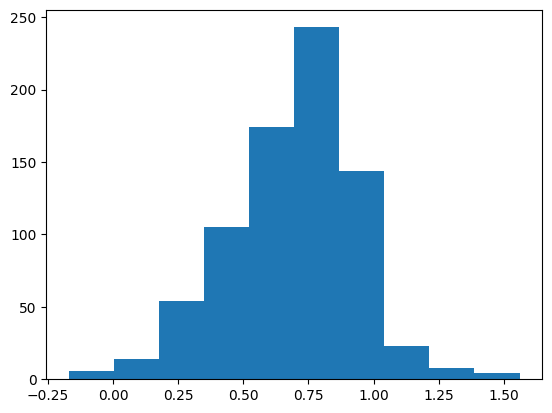

In [104]:
plt.hist(data_ss['stabilityscore_c'][idxs]);

In [53]:
#plt.hist(data3['stabilityscore_c_adj'][idxs])

In [86]:
mutated_seq = data_ss['sequence'][0]
mutated_seq

'TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVKVTR'

In [147]:
from collections import defaultdict
nlls = torch.zeros(sum(idxs))
iterator=0
it2=0
couplings, fields = decoder(rep_padded, padding_mask)
for idx in idxs:
    if idx:
        mutated_seq = data_ss['sequence'][it2]
        q=21
        B=M=1
        N=len(mutated_seq)
        embedding = get_embedding(q)
        alphabet_aux='ACDEFGHIKLMNPQRSTVWY-'
        default_index = alphabet_aux.index('-')
        aa_index = defaultdict(lambda: default_index, {alphabet_aux[i]: i for i in range(len(alphabet_aux))})
        numerical_seq = torch.Tensor([aa_index[c] for c in str(mutated_seq)]).unsqueeze(0).unsqueeze(0)
        numerical_seq = numerical_seq.type(torch.int)
        msas_embedded = embedding(numerical_seq).view(B, M, -1)
        nlls[iterator] = -torch.sum(get_npll(msas_embedded, couplings, fields, N, q)).item()/N
        iterator+=1
    it2+=1

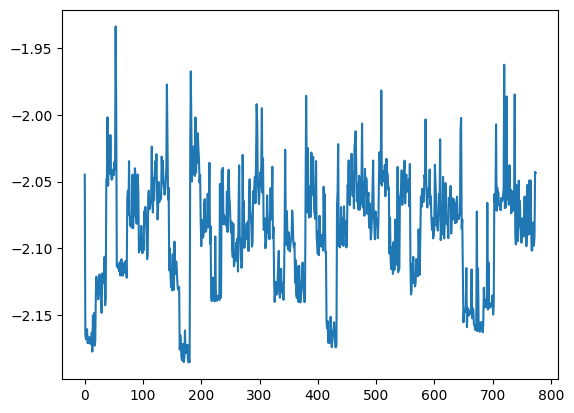

In [148]:
plt.plot(nlls)

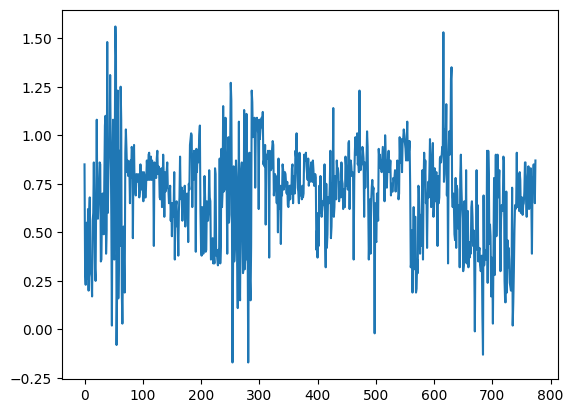

In [149]:
plt.plot(data_ss['stabilityscore_c'][idxs])

In [150]:
fitnesses = data_ss['stabilityscore_t'][idxs]
corr = scipy.stats.spearmanr(fitnesses, nlls)
corr

SpearmanrResult(correlation=0.4755761706461865, pvalue=5.48932153297382e-45)

In [151]:
fitnesses = data_ss['stabilityscore_c'][idxs]
corr = scipy.stats.spearmanr(fitnesses, nlls)
corr

SpearmanrResult(correlation=0.4749559959855183, pvalue=7.377359241508268e-45)

# Let us move to another index

In [6]:
model, alphabet = pretrained.esm_if1_gvp4_t16_142M_UR50() 
model.eval()

GVPTransformerModel(
  (encoder): GVPTransformerEncoder(
    (dropout_module): Dropout(p=0.1, inplace=False)
    (embed_tokens): Embedding(35, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (embed_gvp_input_features): Linear(in_features=15, out_features=512, bias=True)
    (embed_confidence): Linear(in_features=16, out_features=512, bias=True)
    (embed_dihedrals): DihedralFeatures(
      (node_embedding): Linear(in_features=6, out_features=512, bias=True)
      (norm_nodes): Normalize()
    )
    (gvp_encoder): GVPEncoder(
      (embed_graph): GVPGraphEmbedding(
        (embed_node): Sequential(
          (0): GVP(
            (wh): Linear(in_features=3, out_features=256, bias=False)
            (ws): Linear(in_features=263, out_features=1024, bias=True)
            (wv): Linear(in_features=256, out_features=256, bias=False)
          )
          (1): LayerNorm(
            (scalar_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
         

In [15]:
fname3 = 'EEHEE_rd3_0037.pdb'
pdb_folder3 = '/Data/InverseFoldingData/aan-designed-pdbs/rd3'
fpath3 = os.path.join(pdb_folder3, fname3)

structure =  load_structure(fpath3)
coords, native_seq = extract_coords_from_structure(structure)
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)
input_encoding_dim = rep.shape[1]
q=21
param_embed_dim = 512
n_param_heads = 4
d_model = 128
n_heads = 2
n_layers = 2
device = 1
eta = 1e-3
dropout = 0.0


decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)

model_path = '/Data/InverseFoldingData/IntermediateModels/parameters_seed_0_batch_size_4_nheads_2_d_128_nparheads_4_dropout_0.1_eta_0.001_update_2000000_noise_0.02'
decoder.load_state_dict(torch.load(model_path))
decoder.eval();

rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)
padding_mask = torch.zeros((1, rep_padded.shape[1]), dtype=torch.bool)

couplings, fields = decoder(rep_padded, padding_mask)

idxs = ['EEHEE_rd3_0037.pdb' in mut_name for mut_name in data_ss['name']]
print(sum(idxs))

nlls = torch.zeros(sum(idxs))
iterator=0
it2=0
couplings, fields = decoder(rep_padded, padding_mask)
for idx in idxs:
    if idx:
        mutated_seq = data_ss['sequence'][it2]
        q=21
        B=M=1
        N=len(mutated_seq)
        embedding = get_embedding(q)
        alphabet_aux='ACDEFGHIKLMNPQRSTVWY-'
        default_index = alphabet_aux.index('-')
        aa_index = defaultdict(lambda: default_index, {alphabet_aux[i]: i for i in range(len(alphabet_aux))})
        numerical_seq = torch.Tensor([aa_index[c] for c in str(mutated_seq)]).unsqueeze(0).unsqueeze(0)
        numerical_seq = numerical_seq.type(torch.int)
        msas_embedded = embedding(numerical_seq).view(B, M, -1)
        nlls[iterator] = -torch.sum(get_npll(msas_embedded, couplings, fields, N, q)).item()/N
        iterator+=1
    it2+=1

775


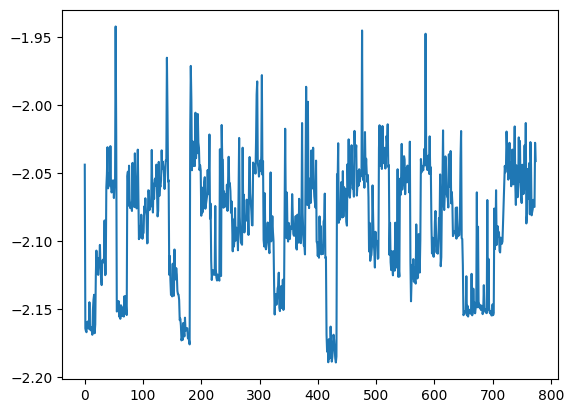

In [16]:
plt.plot(nlls)

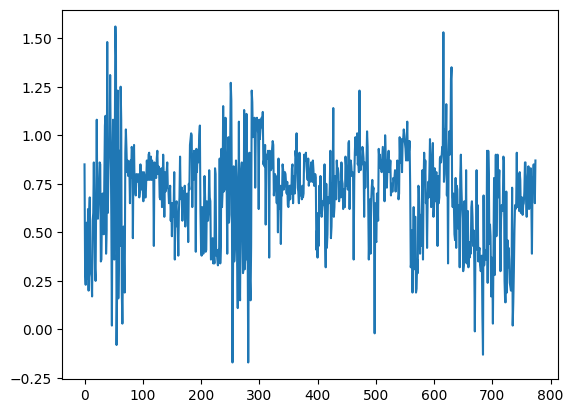

In [17]:
plt.plot(data_ss['stabilityscore_c'][idxs])

In [18]:
fitnesses = data_ss['stabilityscore_c'][idxs]
corr = scipy.stats.spearmanr(fitnesses, nlls)
corr

SpearmanrResult(correlation=0.4710776738670512, pvalue=4.621727406459006e-44)

In [180]:
view_pdb(fpath3)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Let us analyze the Potts model under consideration.

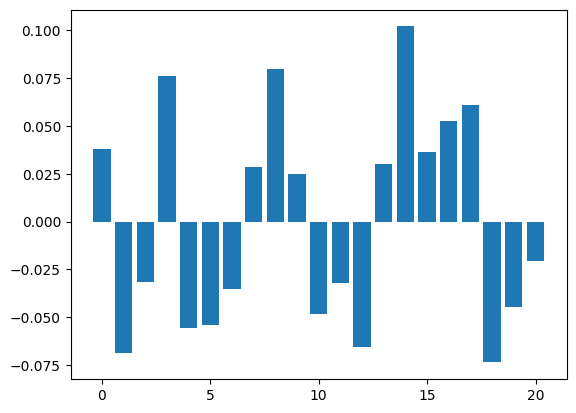

In [14]:
pos = N-10 ## pos goes from 1 to N
plt.bar(range(q), (fields[0, (pos-1)*21:pos*21]).detach().numpy());

In [47]:
fields.shape

torch.Size([1, 903])

In [16]:
import seaborn as sns
import matplotlib.pylab as plt

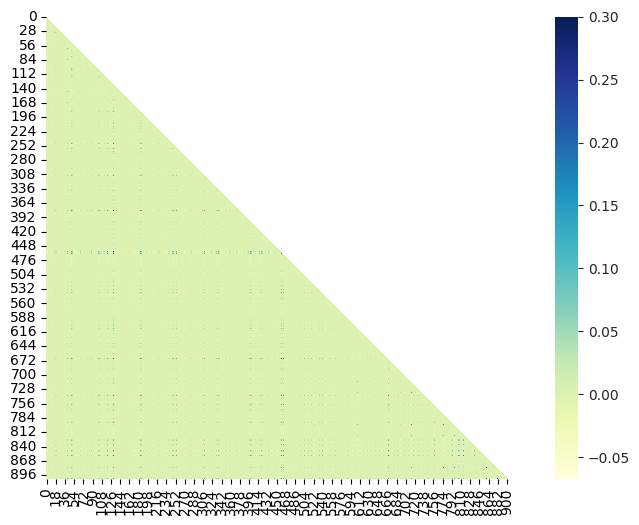

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
mask = np.zeros_like(couplings.detach().numpy()[0, ::, ::])
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(couplings.detach().numpy()[0, :: , ::], mask=mask, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()

This does not seem very usefull... too much information in a single graph.

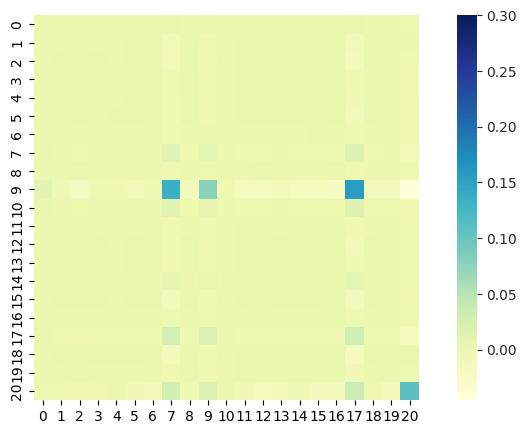

In [19]:
##pos1 pos2 go from 1 to N
pos1 = 2
pos2 = 3
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
with sns.axes_style("white"):
    ax = sns.heatmap(couplings.detach().numpy()[0, (pos1-1)*21:pos1*21, (pos2-1)*21:pos2*21], vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()

Observation: we seem to have no negaitve couplings, almost all positive.

In [29]:
output = np.zeros((N, N))
for i in range(N):
    for j in range(i+1, N):
        c = couplings[0, i*21:(i+1)*21, j*21:(j+1)*21].detach().numpy()
        c = c - np.mean(c, axis=0) - np.mean(c, axis=1) + np.mean(c)

        output[i,j] = np.sum(c**2)

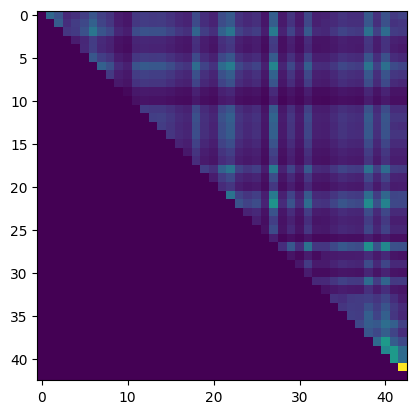

In [31]:
plt.imshow(output)